In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import os, sys

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo
from fractions import Fraction

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])
load_directory = top_directory + '/LoadFiles/InstrumentFiles/'

sys.path.insert(0,top_directory + '/Functions')
import StrainandNoise as SnN

LISA_Other_filedirectory = load_directory + 'LISA_Other/StrainFiles/'
LISA_Neil_filedirectory = load_directory + 'LISA_Neil/StrainFiles/'
LISA_ESA_filedirectory = load_directory + 'LISA_ESA/StrainFiles/'
ET_filedirectory = load_directory + 'EinsteinTelescope/StrainFiles/'
aLIGO_filedirectory = load_directory + 'aLIGO/StrainFiles/'
NANOGrav_filedirectory = load_directory + 'NANOGrav/StrainFiles/' 

In [5]:
axissize = 14
labelsize = 16
legendsize = 12
figsize = (10,8)
colornorm = colors.Normalize(vmin=0.0, vmax=5.0)
linesize = 2

In [6]:
L = 2.5*u.Gm  #armlength in Gm
L = L.to('m')

####################################################################
# Load data files for transfer function and other sensitivity curves

### LISA Transfer Function

In [103]:
fT,LISA_Transfer_Function = SnN.Get_TransferFunction(L=L)
LISA_T_obs = 4*u.yr
LISA_T_obs = LISA_T_obs.to('s')

### aLIGO

In [8]:
#aLIGO
aLIGO_filename = 'aLIGODesign.txt'
aLIGO_filelocation = aLIGO_filedirectory + aLIGO_filename
aLIGO_data = np.loadtxt(aLIGO_filelocation)
aLIGO_f = aLIGO_data[:,0]*u.Hz
aLIGO_S_n_f = aLIGO_data[:,1]

### Einstein Telescope

In [104]:
#Einstein Telescope
ET_T_obs = 5*u.yr
ET_T_obs = ET_T_obs.to('s')
ET_filename = 'ET_B_data.txt'
ET_filelocation = ET_filedirectory + ET_filename
ET_data = np.loadtxt(ET_filelocation)
ET_f = ET_data[:,0]*u.Hz
ET_S_n_f = ET_data[:,1]

### LISA Martin data

In [10]:
#Martin data
LISA_Martin_filename = 'LISA_Allocation_S_h_tot.txt'
LISA_Martin_filelocation = LISA_Other_filedirectory + LISA_Martin_filename
LISA_Martin_data = np.loadtxt(LISA_Martin_filelocation)
LISA_Martin_f = LISA_Martin_data[:,0]*u.Hz
LISA_Martin_S_n_f = LISA_Martin_data[:,1]/u.Hz

### LISA Neil Cornish data

In [11]:
#Neil Cornish data
LISA_Neil_filename = 'LISA_sensitivity.txt'
LISA_Neil_filelocation = LISA_Neil_filedirectory + LISA_Neil_filename
LISA_Neil_data = np.loadtxt(LISA_Neil_filelocation)
LISA_Neil_f = LISA_Neil_data[:,0]*u.Hz
LISA_Neil_S_n_f = LISA_Neil_data[:,1]/u.Hz

### LISA Larson Sensitivity Curve

In [12]:
#Larson Sensitivity Curve
LISA_Larson_filename = 'scg_6981.dat'
LISA_Larson_filelocation = LISA_Other_filedirectory + LISA_Larson_filename
LISA_Larson_data = np.loadtxt(LISA_Larson_filelocation)
LISA_Larson_f = LISA_Larson_data[:,0]*u.Hz
LISA_Larson_S_n_f = LISA_Larson_data[:,1]/u.Hz #May be wrong units

### NANOGrav continuous wave sensitivity

In [71]:
#NANOGrav continuous wave sensitivity
NANOGrav_background = 4e-16 # Unsubtracted GWB amplitude: 0,4e-16
NANOGrav_dp = 0.95 #Detection Probablility: 0.95,0.5
NANOGrav_fap = 0.0001 #False Alarm Probability: 0.05,0.003,0.001,0.0001
NANOGrav_Tobs = 15 #Observation years: 15,20,25

NANOGrav_filename = 'cw_simulation_Ared_' + str(NANOGrav_background) + '_dp_' + str(NANOGrav_dp) \
                    + '_fap_' + str(NANOGrav_fap) + '_T_' + str(NANOGrav_Tobs) + '.txt'
NANOGrav_filelocation = NANOGrav_filedirectory + NANOGrav_filename
NANOGrav_data = np.loadtxt(NANOGrav_filelocation)
NANOGrav_file_f = NANOGrav_data[:,0]*u.Hz
NANOGrav_file_h_f = NANOGrav_data[:,1]

In [72]:
#NANOGrav continuous wave sensitivity
NANOGrav_background_2 = 0 # Unsubtracted GWB amplitude: 0,4e-16
NANOGrav_dp_2 = 0.95 #Detection Probablility: 0.95,0.5
NANOGrav_fap_2 = 0.0001 #False Alarm Probability: 0.05,0.003,0.001,0.0001
NANOGrav_Tobs_2 = 15 #Observation years: 15,20,25

NANOGrav_filename_2 = 'cw_simulation_Ared_' + str(NANOGrav_background_2) + '_dp_' + str(NANOGrav_dp_2) \
                    + '_fap_' + str(NANOGrav_fap_2) + '_T_' + str(NANOGrav_Tobs_2) + '.txt'
NANOGrav_filelocation_2 = NANOGrav_filedirectory + NANOGrav_filename_2
NANOGrav_data_2 = np.loadtxt(NANOGrav_filelocation_2)
NANOGrav_file_f_2 = NANOGrav_data_2[:,0]*u.Hz
NANOGrav_file_h_f_2 = NANOGrav_data_2[:,1]

### SKA  parameters and methods from arXiv:0804.4476 section 7.1

In [73]:
###############################################
#SKA calculation using parameters and methods from arXiv:0804.4476 section 7.1
deltrms_SKA = 10*u.ns #rms timing residuals in nanoseconds
deltrms_SKA = deltrms_SKA.to('s')

T_SKA = 20*u.yr #Observing time in years
T_SKA = T_SKA.to('s') #Observing time in seconds

Np_SKA = 20 #Number of pulsars
cadence_SKA = 1/u.wk #Avg observation cadence of 1 every week in seconds
cadence_SKA = cadence_SKA.to('1/s')

### NANOGrav 11.5yr parameters https://arxiv.org/abs/1801.01837

In [74]:
###############################################
#NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
deltrms_nano = 100*u.ns #rms timing residuals in seconds
deltrms_nano = deltrms_nano.to('s')

T_nano = 15*u.yr #Observing time in years
T_nano = T_nano.to('s') #Observing time in seconds
Np_nano = 18 #Number of pulsars
cadence_nano = 1/(2*u.wk) #Avg observation cadence of 1 every 2 weeks in seconds
cadence_nano = cadence_nano.to('1/s')

### Calculate PTA Strains using Lam, M.T. 2018 https://arxiv.org/pdf/1808.10071.pdf

In [75]:
ndetectors = 2
T_obs_full = [T_nano, T_SKA]
cadence_full = [cadence_nano, cadence_SKA]
sigma_rms_full = [deltrms_nano, deltrms_SKA]

SKA_f,SKA_S_n_f = SnN.calcPTAASD(sigma_rms_full,cadence_full,T_obs_full,ndetectors)
[f_SKA,SKA_strain] = SnN.CalcPTAstrain(sigma_rms_full,cadence_full,T_obs_full,ndetectors,Np_SKA)
[_,ska_S_n_f] = SnN.CalcPTAASD_v2(sigma_rms_full,cadence_full,T_obs_full,ndetectors,Np_SKA)

In [76]:
ndetectors = 1

NANOGrav_f,NANOGrav_S_n_f = SnN.calcPTAASD(deltrms_nano,cadence_nano,T_nano,ndetectors)
[f_nano,nano_strain] = SnN.CalcPTAstrain(deltrms_nano,cadence_nano,T_nano,ndetectors,Np_nano)
[_,nano_S_n_f] = SnN.CalcPTAASD_v2(deltrms_nano,cadence_nano,T_nano,ndetectors,Np_nano)

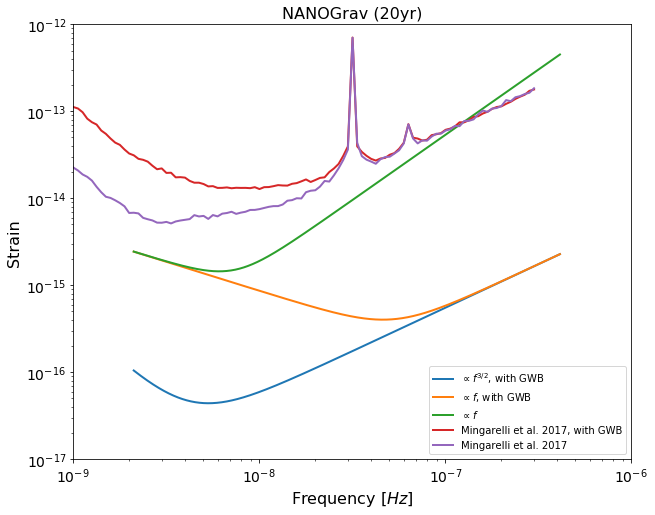

In [77]:
plt.figure(figsize=(10,8))
plt.loglog(f_nano,nano_strain, linewidth = linesize,label = r'$\propto f^{3/2}$, with GWB')
plt.loglog(f_nano,np.sqrt(f_nano)*nano_S_n_f, linewidth = linesize,label = r'$\propto f$, with GWB')
plt.loglog(NANOGrav_f,np.sqrt(NANOGrav_f)*NANOGrav_S_n_f, linewidth = linesize,label = r'$\propto f$')
plt.loglog(NANOGrav_file_f,NANOGrav_file_h_f, linewidth = linesize,label = 'Mingarelli et al. 2017, with GWB')
plt.loglog(NANOGrav_file_f_2,NANOGrav_file_h_f_2, linewidth = linesize,label = 'Mingarelli et al. 2017')


plt.tick_params(axis = 'both',which = 'major', labelsize = axissize)
plt.ylim([1e-17,1e-12])
plt.xlim([1e-9,1e-6])
plt.title('NANOGrav (20yr)',fontsize=labelsize)
plt.xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
plt.ylabel('Strain',fontsize = labelsize)
plt.legend(loc='lower right', fontsize = 10)
plt.show()

In [78]:
cadence_5yr = 1/2/u.wk
cadence_5yr = cadence_5yr.to('1/s')
T_5yr = 5*u.yr
T_5yr = T_5yr.to('s')
rms_error_5yr = 100*u.ns
rms_error_5yr = rms_error_5yr.to('s')
Np_5yr = 36
[f_approx_5yr, h_approx_5yr] = SnN.CalcPTAstrain(rms_error_5yr,cadence_5yr,T_5yr,1,Np_5yr)
[f_approx_5yr_2,S_n_f_approx_5yr] = SnN.CalcPTAASD_v2(rms_error_5yr,cadence_5yr,T_5yr,1,Np_5yr)

In [79]:
A_stoch_back = 4e-16
f_year = 1/u.yr
f_SB = np.logspace(np.log10(1/T_5yr.value),np.log10(cadence_5yr.value/2),1e3)*u.Hz
h_SB = A_stoch_back*(f_SB/f_year.to('Hz'))**(-2/3)

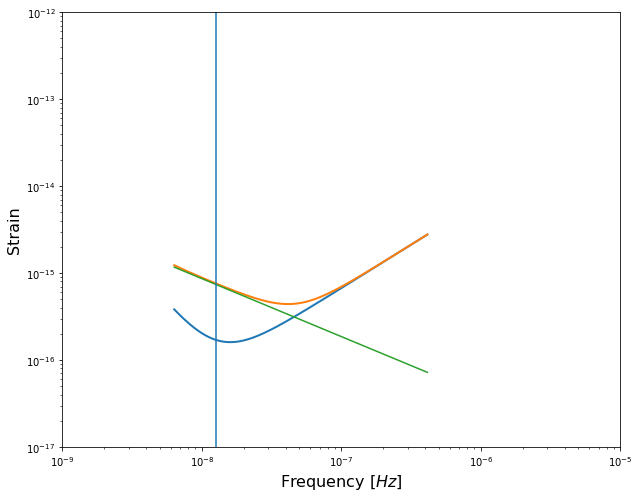

In [80]:
plt.figure(figsize=(10,8))
plt.loglog(f_approx_5yr,h_approx_5yr, linewidth = linesize)
plt.loglog(f_approx_5yr_2,np.sqrt(f_approx_5yr_2)*S_n_f_approx_5yr,linewidth=linesize)
plt.loglog(f_SB,h_SB)
plt.axvline(x=2/T_5yr.value)
plt.xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
plt.ylabel('Strain',fontsize = labelsize)
plt.ylim([1e-17, 1e-12])
plt.xlim([1e-9, 1e-5])
plt.show()

####################################################################
# Calculate LISA amplitude spectral densities for various models

### LISA Calculation without pathfinder correction (2016 model)

In [81]:
#LISA Calculation without pathfinder correction (2016 model)
Ssci = 8.9e-12**2*u.m*u.m
Sloc = 1.7e-12**2*u.m*u.m
Sother = 2e-12**2*u.m*u.m
k2016_P_ims = Ssci+2*Sloc+Sother
k2016_P_acc = ((1.8e-14*u.m/u.s/u.s)**2*((3e-5*u.Hz/fT)**10 + (1e-4*u.Hz/fT)**2) + (3e-15*u.m/u.s/u.s)**2)/(2*np.pi*fT)**4   #red below 1e-4, white above
k2016_S_n_f = SnN.calcASD(fT,LISA_Transfer_Function,k2016_P_acc,k2016_P_ims,L)

### LISA Calculation WITH (Sean's) pathfinder correction

In [82]:
#LISA Calculation WITH (Sean's) pathfinder correction
pathfinder_S_acc = ((60e-15*u.m/u.s/u.s)**2*(20e-6*u.Hz/fT)**10 + (1.74e-15*u.m/u.s/u.s)**2)/(2*np.pi*fT)**4 #Update Pathfinder Acceleration Noise
pathfinder_S_n_f = SnN.calcASD(fT,LISA_Transfer_Function,pathfinder_S_acc,k2016_P_ims,L) #Updated LISA noise curve with Pathfinder Acc noise

### LISA Calculation from https://arxiv.org/pdf/1702.00786.pdf (Amaro-Seaone 2017)

In [83]:
S_acc_low_knee = .4*u.mHz
S_acc_high_knee = 8.*u.mHz
S_oms_knee = 2.*u.mHz
ESA_S_n_f = SnN.LisaSensitivity(fT,LISA_Transfer_Function)

### Neil Calculation from https://arxiv.org/pdf/1803.01944.pdf

In [84]:
#Neil Calculation from https://arxiv.org/pdf/1803.01944.pdf
Neil_S_acc = 3e-15*u.m/u.s/u.s #M/sqrt(Hz)
Neil_S_oms = 1.5e-11*u.m
Neil_S_n_f = SnN.NeilSensitivity(fT,LISA_Transfer_Function)

#######################################################################
# BBH strain calculation

In [98]:
#Vars = [M,q,chi1,chi2,z]
M = [1e6,65.0,1e10]
q = [1.0,18.0,1.0]
x1 = [0.95,0.0,-0.95]
x2 = [0.95,0.0,-0.95]
z = [3.0,0.093,20.0]

Vars1 = [M[0],q[0],x1[0],x2[0],z[0]]
Vars2 = [M[1],q[1],x1[1],x2[1],z[1]]
Vars3 = [M[2],q[2],x1[2],x2[2],z[2]]

In [99]:
print(Vars1)
print(Vars2)
print(Vars3)

[1000000.0, 1.0, 0.95, 0.95, 3.0]
[65.0, 18.0, 0.0, 0.0, 0.093]
[10000000000.0, 1.0, -0.95, -0.95, 20.0]


In [100]:
#From PhenomD
[phenomD_f_1,phenomD_h_1] = SnN.Get_Waveform(Vars1,f_low=1e-4)
[phenomD_f_2,phenomD_h_2] = SnN.Get_Waveform(Vars2,f_low=1e-4)
[phenomD_f_3,phenomD_h_3] = SnN.Get_Waveform(Vars3)

In [101]:
#Get characteristic strain
[phenomD_f_1,phenomD_h_char_1] = SnN.Get_CharStrain(Vars1,phenomD_f_1,phenomD_h_1)
[phenomD_f_2,phenomD_h_char_2] = SnN.Get_CharStrain(Vars2,phenomD_f_2,phenomD_h_2)
[phenomD_f_3,phenomD_h_char_3] = SnN.Get_CharStrain(Vars3,phenomD_f_3,phenomD_h_3)

In [108]:
#Get monochromatic strain
[mono_idx_1,h_mono_1] = SnN.Get_MonoStrain(Vars1,LISA_T_obs,fT[np.argmin(ESA_S_n_f)],fT)
[mono_idx_2,h_mono_2] = SnN.Get_MonoStrain(Vars2,ET_T_obs,ET_f[np.argmin(ET_S_n_f)],ET_f)
[mono_idx_3,h_mono_3] = SnN.Get_MonoStrain(Vars3,T_nano,NANOGrav_f[np.argmin(NANOGrav_S_n_f)],NANOGrav_f)

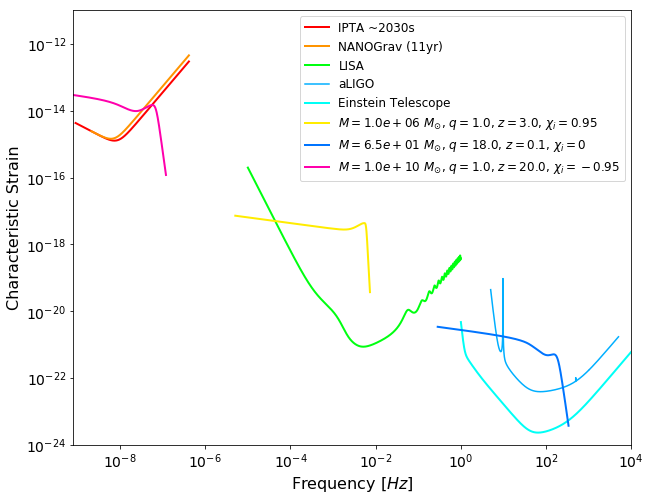

In [110]:
plt.figure(figsize = figsize)
#plt.loglog(NANOGrav_f,NANOGrav_h_f)
plt.loglog(SKA_f,np.sqrt(SKA_f)*SKA_S_n_f, linewidth = linesize,color = cm.hsv(colornorm(0.0)),label = 'IPTA ~2030s')
plt.loglog(NANOGrav_f,np.sqrt(NANOGrav_f)*NANOGrav_S_n_f, linewidth = linesize,color = cm.hsv(colornorm(0.5)),label = 'NANOGrav (11yr)')
plt.loglog(fT,np.sqrt(fT)*ESA_S_n_f, linewidth = linesize,color = cm.hsv(colornorm(1.75)),label = 'LISA')
plt.loglog(aLIGO_f,np.sqrt(aLIGO_f)*aLIGO_S_n_f,color = cm.hsv(colornorm(2.8)),label = 'aLIGO')
plt.loglog(ET_f,np.sqrt(ET_f)*ET_S_n_f, linewidth = linesize,color = cm.hsv(colornorm(2.5)),label = 'Einstein Telescope')
plt.loglog(phenomD_f_1,phenomD_h_char_1, linewidth = linesize,color = cm.hsv(colornorm(0.8)),label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.2f$' %(M[0],q[0],z[0],x1[0]))
plt.loglog(phenomD_f_2,phenomD_h_char_2, linewidth = linesize,color = cm.hsv(colornorm(3.0)),label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.0f$' %(M[1],q[1],z[1],x1[1]))
plt.loglog(phenomD_f_3,phenomD_h_char_3, linewidth = linesize,color = cm.hsv(colornorm(4.5)),label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.2f$' %(M[2],q[2],z[2],x1[2]))
'''plt.scatter(fT[mono_idx_1],h_mono_1)
plt.scatter(ET_f[mono_idx_2],h_mono_2)
plt.scatter(NANOGrav_f[mono_idx_3],h_mono_3)'''


plt.xlim([8e-10, 1e4])
plt.ylim([1e-24, 1e-11])
plt.tick_params(axis = 'both',which = 'major', labelsize = axissize)

plt.xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
plt.ylabel('Characteristic Strain',fontsize = labelsize)
plt.legend(loc='upper right', fontsize = legendsize)
plt.show()

In [30]:
#########################
#Save Figure to File
figloc = fig_filedirectory+figname
if isitsavetime:
    plt.savefig(figloc, format=figformat, dpi=figdpi)

NameError: name 'fig_filedirectory' is not defined